In [22]:
import numpy as np
import h5py
import os

# Data
tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
results_dir = './outputs/'

def read_results(filename):
    signal_magnitude = []       
    filepath = os.path.join(results_dir, f'{filename}.h5')
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])     
        S = np.array(h5['scales'])  
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type)
            # M_f = M[ids, mask, :, :]      
            M_f = M[ids, :, :, :]             
            M_f = np.mean(M_f[...,:-1,0:2], axis=0)            
            signal_magnitude.append(np.linalg.norm(M_f, axis=-1))    
    return signal_magnitude

############
radius = 8
oxy_level = [78, 85]
orientation = 90

signal_magnitude = []
for o in oxy_level:
    filename = f'grase_{o}_r{radius}_Y0.0_BVF{4}_ori{orientation}_fov600_res1200'
    signal_magnitude.append(read_results(filename))

signal_magnitude = np.array(signal_magnitude)
print(signal_magnitude.shape)
signal_change_grase1 = 100 * (1 - signal_magnitude[0,...] / signal_magnitude[1,...])
signal_change_grase2 = signal_magnitude[1,...] - signal_magnitude[0,...]

with h5py.File(os.path.join(results_dir, f'{filename}.h5'), 'r') as h5:
    scales = np.array(h5['scales']).squeeze()
    TE =np.array(h5['TE']).squeeze()[:signal_magnitude.shape[2]]

# save as mat file
import scipy.io as sio
sio.savemat(os.path.join(results_dir, 'signal_change_grase.mat'), {'radius':radius, 'scales':scales, 'signal_change_grase1': signal_change_grase1, 'signal_change_grase2': signal_change_grase2,  'TE': TE})

(2, 50, 18)


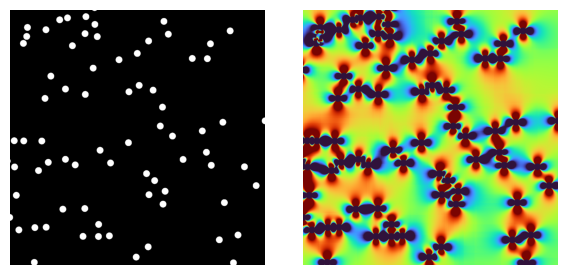

In [15]:
import h5py
import matplotlib.pyplot as plt

def plot_phantom(file_path, title=None):
    with h5py.File(file_path, "r") as f:
        mask = f["mask"][()]
        fieldmap = f["fieldmap"][()]
        sz = tuple(dim // 2 for dim in mask.shape)
        # print orthogonal views
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].imshow(mask[:, :, sz[2]], cmap="gray")
        axes[0].axis("off")
        axes[1].imshow(fieldmap[:, :, sz[2]], cmap="turbo", vmin=-8e-8, vmax=8e-8)
        axes[1].axis("off")
        # title
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

# show the phantom
phantom_file = "./phantoms/r8_Y0.0_BVF4_ori90_fov600_res1200.h5"
plot_phantom(phantom_file)


In [23]:
# load mat file
import os
import numpy as np
import scipy.io as sio
results_dir = './outputs/'
data = sio.loadmat(os.path.join(results_dir, 'signal_change_grase.mat'))
signal_change_grase1  = np.array(data['signal_change_grase1'])
signal_change_grase2  = np.array(data['signal_change_grase2'])

TE     = data['TE']
scales = data['scales']
radius = data['radius']

print(signal_change_grase1.shape, TE.size)
print(radius)
print(scales)

(50, 18) 18
[[8]]
[[1.25000e-02 1.47000e-02 1.73000e-02 2.04000e-02 2.40000e-02 2.83000e-02
  3.33000e-02 3.92000e-02 4.62000e-02 5.44000e-02 6.41000e-02 7.54000e-02
  8.88000e-02 1.04600e-01 1.23100e-01 1.45000e-01 1.70700e-01 2.01000e-01
  2.36700e-01 2.78700e-01 3.28200e-01 3.86500e-01 4.55100e-01 5.35800e-01
  6.30900e-01 7.42900e-01 8.74800e-01 1.03010e+00 1.21290e+00 1.42820e+00
  1.68170e+00 1.98030e+00 2.33180e+00 2.74560e+00 3.23300e+00 3.80690e+00
  4.48260e+00 5.27830e+00 6.21520e+00 7.31840e+00 8.61740e+00 1.01470e+01
  1.19481e+01 1.40689e+01 1.65662e+01 1.95067e+01 2.29692e+01 2.70463e+01
  3.18471e+01 3.75000e+01]]


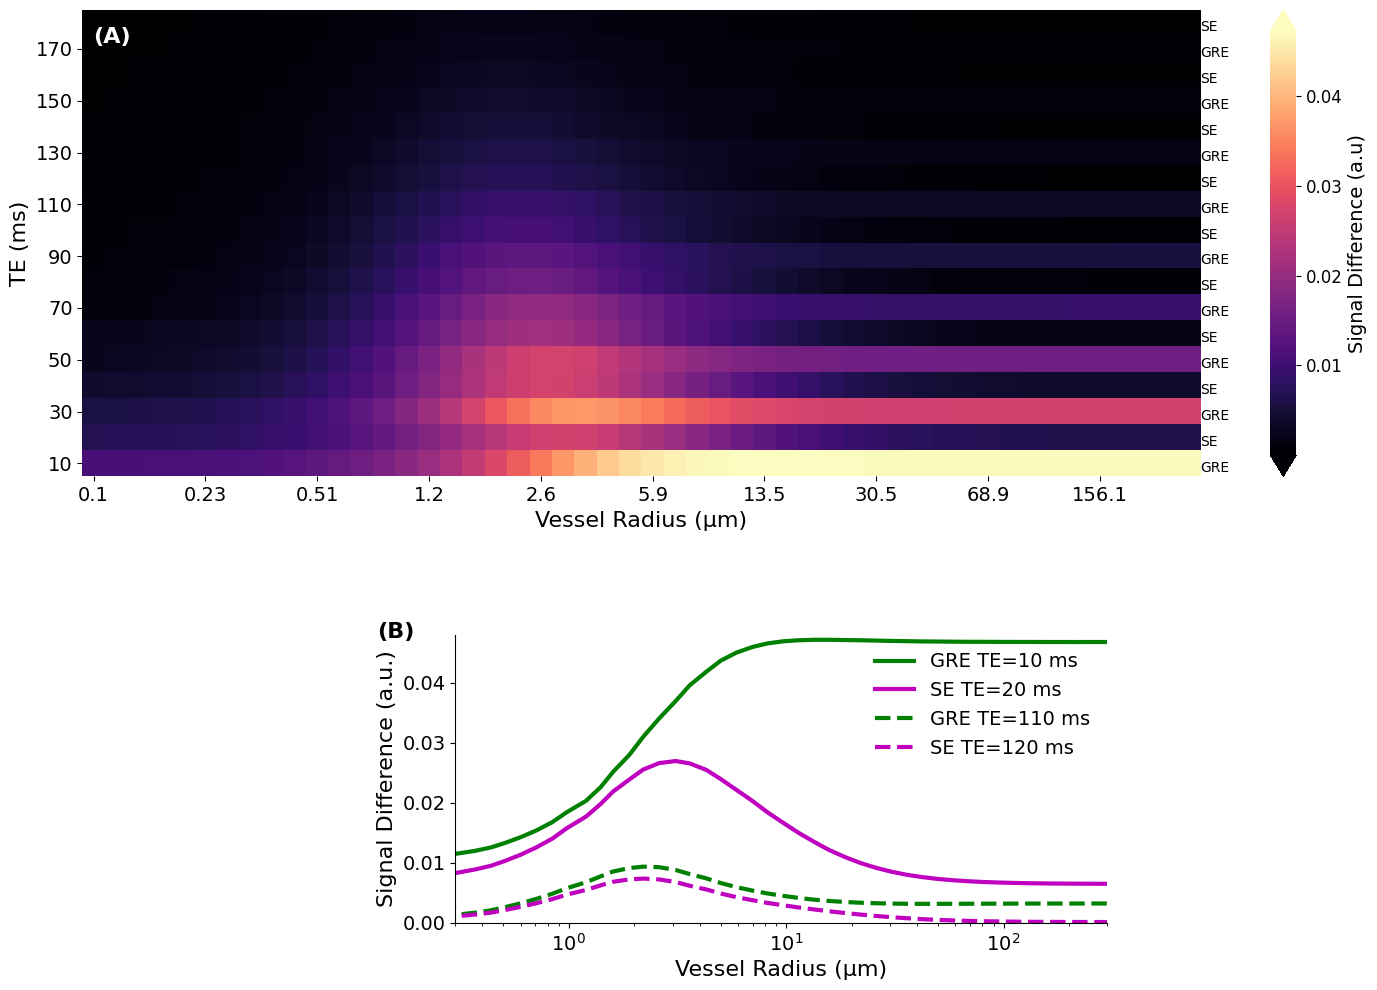

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

plt.close('all')

TE     = data['TE']

x = radius * scales.squeeze()
x = x.reshape(-1)
x = np.where(x < 1, np.round(x, 2), np.round(x, 1))
TE = (np.round(TE.reshape(-1), 2) * 1000).astype(int)
fig = plt.figure(figsize=(15, 10))
gs  = fig.add_gridspec(11,4)

ax1 = fig.add_subplot(gs[0:6, :])
im = ax1.imshow(signal_change_grase2.transpose(), cmap = "magma", aspect='auto')
ax1.set_xticks(ticks=np.arange(x.size), labels=x)
ax1.set_yticks(ticks=np.arange(TE.size), labels=TE)
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax1.invert_yaxis()    
ax1.set_xlabel('Vessel Radius (µm)', fontsize=16)
ax1.set_ylabel('TE (ms)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax1.text(0.01, 0.93, '(A)', transform=ax1.transAxes, fontsize=16, weight='bold', color='white')

ax1.patch.set_visible(False)

echo_type =[ 'GRE', 'SE']
for i in range(0, TE.size):
    ax1.text(1, i/TE.size+0.01, echo_type[i%2], transform=ax1.transAxes, fontsize=10)
    
cbar = fig.colorbar(im, ax=ax1, orientation='vertical', extend='both', pad=0.05, aspect=18)
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Signal Difference (a.u)', fontsize=14)

ax2 = fig.add_subplot(gs[7:, 1:3])
ax2.plot(x, signal_change_grase2.transpose()[0,:],  'g-',  label=f'GRE TE={TE[0]} ms', linewidth=3)
ax2.plot(x, signal_change_grase2.transpose()[1,:],  'm-',  label=f'SE TE={TE[1]} ms', linewidth=3)
ax2.plot(x, signal_change_grase2.transpose()[10,:], 'g--', label=f'GRE TE={TE[10]} ms', linewidth=3)
ax2.plot(x, signal_change_grase2.transpose()[11,:], 'm--', label=f'SE TE={TE[11]} ms', linewidth=3)
ax2.legend(frameon=False, fontsize=14)
ax2.set_xlabel('Vessel Radius (µm)', fontsize=16)
ax2.set_ylabel('Signal Difference (a.u.)', fontsize=16)
ax2.set_xscale('log')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim([0.3, 300])
ax2.set_ylim([0.0, 0.048])
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.text(-0.12, 0.99, '(B)', transform=ax2.transAxes, fontsize=16, weight='bold')
ax2.patch.set_visible(False)

# fig.patch.set_visible(False)
fig.tight_layout()
# plt.savefig('./figures/grase.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig('../figures_pdf/grase.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()